In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Defining a testing signal, for this I take a sinoid with a small Gaussian pulse on it (only positive)

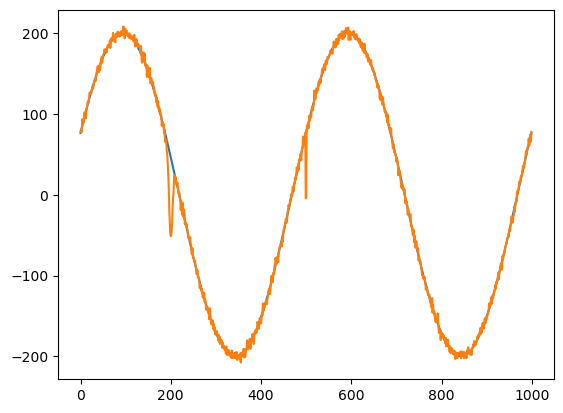

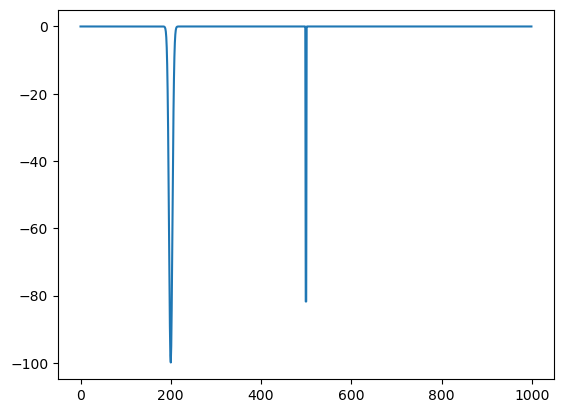

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import gausspulse

loading = 'compression'
lf_amplitude=200
hf_amplitude=-100
no_samples=1000
lf_frequency=2
hf_duration=10
hf_occurence=24
noise_amplitude = 4

t = np.linspace(0, 1, no_samples)   # Timevector

y_lf = lf_amplitude*np.sin(
    2*np.pi*t*lf_frequency + np.pi/8
)

_ , y_hf = gausspulse(t - 0.2, fc=200, retenv=True)
y_hf = y_hf * hf_amplitude

_ , y_hf2 = gausspulse(t - 0.5, fc=2000, retenv=True)
y_hf2 = y_hf2 * hf_amplitude*2

_ , y_hf3 = gausspulse(t - 0.4, fc=2000, retenv=True)
y_hf3 = y_hf3 * (-hf_amplitude)

y_hf = y_hf + y_hf2 #+ y_hf3

# Add noise to y_lf data
y_noise = np.random.normal(0, noise_amplitude, no_samples)

plt.plot(y_lf)
plt.plot(y_hf+y_lf+y_noise)
plt.show()
plt.plot(y_hf)
plt.show()

# plt.xlim([400,600])

In [48]:
from filter_tc.timeseries import temp_comp_pf
from sklearn.linear_model import LinearRegression
def learn_alpha(strain, temperature):
    linregr = LinearRegression()
    linregr.fit(strain, temperature)
    alpha = linregr.coef_[0]
    return alpha

# Trying to better understand the functionality

Introducing just the ParticleFilter element. To understand how it works.

In [49]:
# NOTE: Adapt the Particle Filter to the new data problem at hand
from filter_tc.particle_filter import ParticleFilter

0.9974872718671515


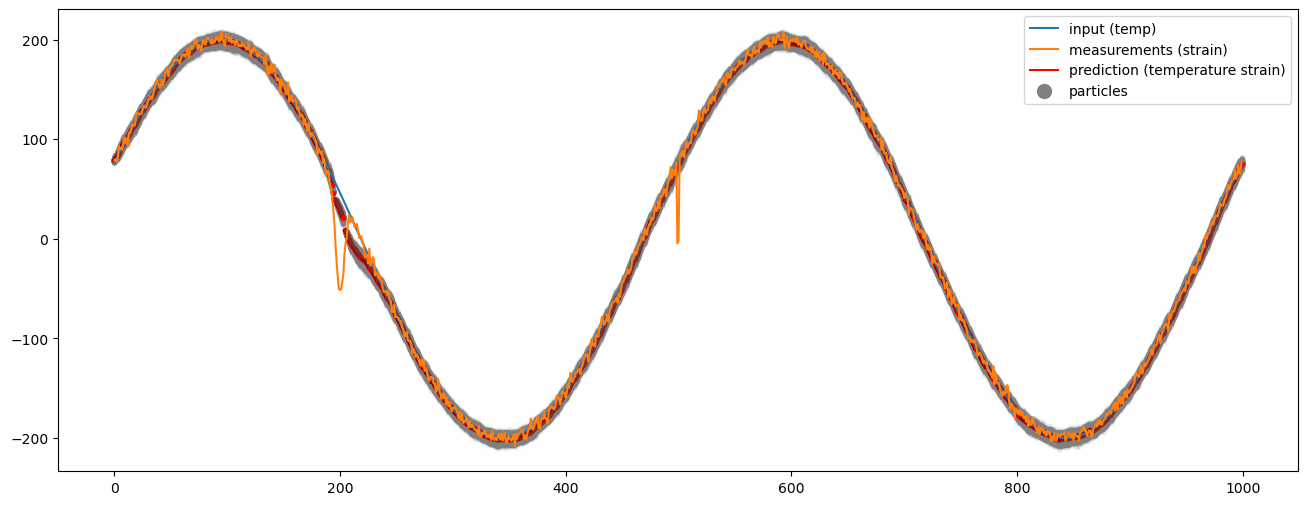

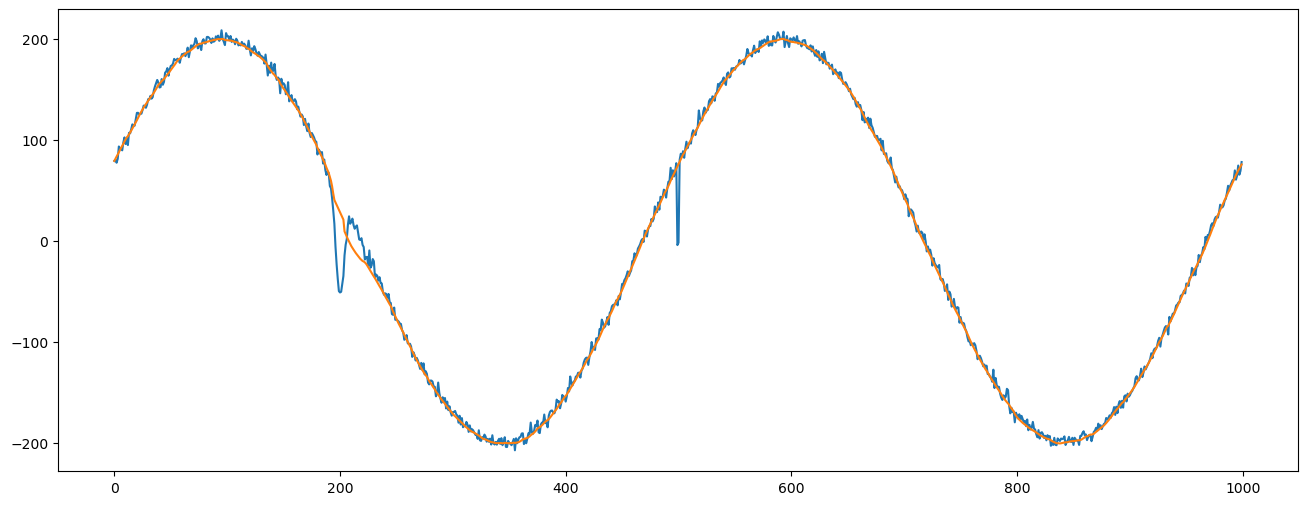

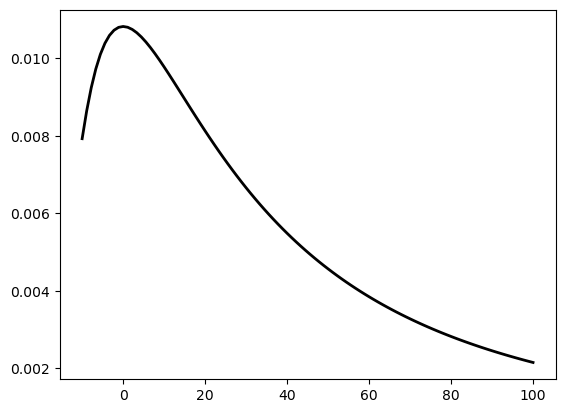

In [51]:
from matplotlib.lines import Line2D

measurements = y_lf+y_noise+y_hf
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

num_particles=1000


pf_alpha = learn_alpha(input[0].reshape(-1, 1),measurements)
print(pf_alpha)
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([1, 1]),
    loc=-25,
    alpha = pf_alpha)

plt.figure(figsize=(16,6))
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([0.1, 0.1]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement)
    #print(self.particles, self.weights)
    pf.simple_resample()
    #print(self.particles, self.weights)
    prediction = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles, marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r')

plt.plot(y_lf, label='input (temp)')
plt.plot(measurements, label='measurements (strain)')

handles, labels = plt.gca().get_legend_handles_labels()
prediction_handle = Line2D([0], [0], label='prediction (temperature strain)', color='r')
scatter_particles_handle = Line2D([0], [0], label='particles', marker='o', markersize=10, markeredgecolor='grey', markerfacecolor='gray', linestyle='')
handles.extend([prediction_handle, scatter_particles_handle])
plt.legend(handles=handles, loc='upper right')
# plt.ylim([-10,10])
plt.show()

plt.figure(figsize=(16,6))
plt.plot(measurements)
plt.plot(pf.predictions)

plt.show()

# plot noise ditribution
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

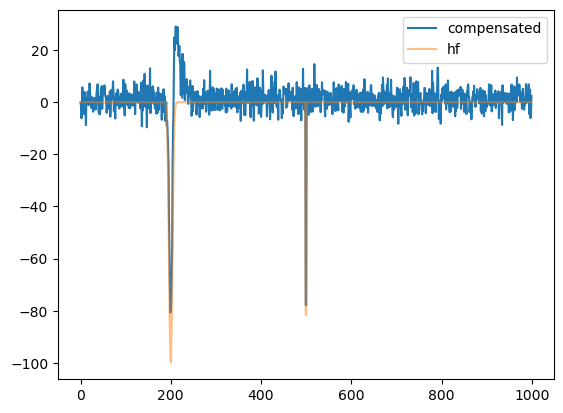

In [52]:
plt.plot(measurements-pf.predictions, label='compensated')
plt.plot(y_hf, label='hf', alpha=0.5)
plt.legend()

## Testing on a different scale influence between input and measurements

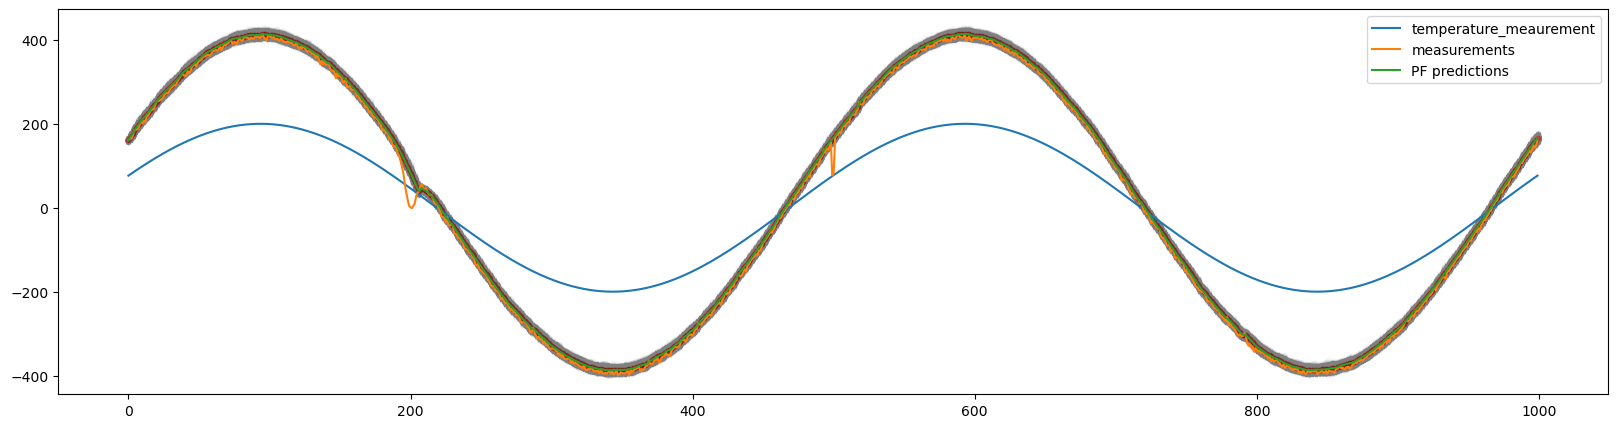

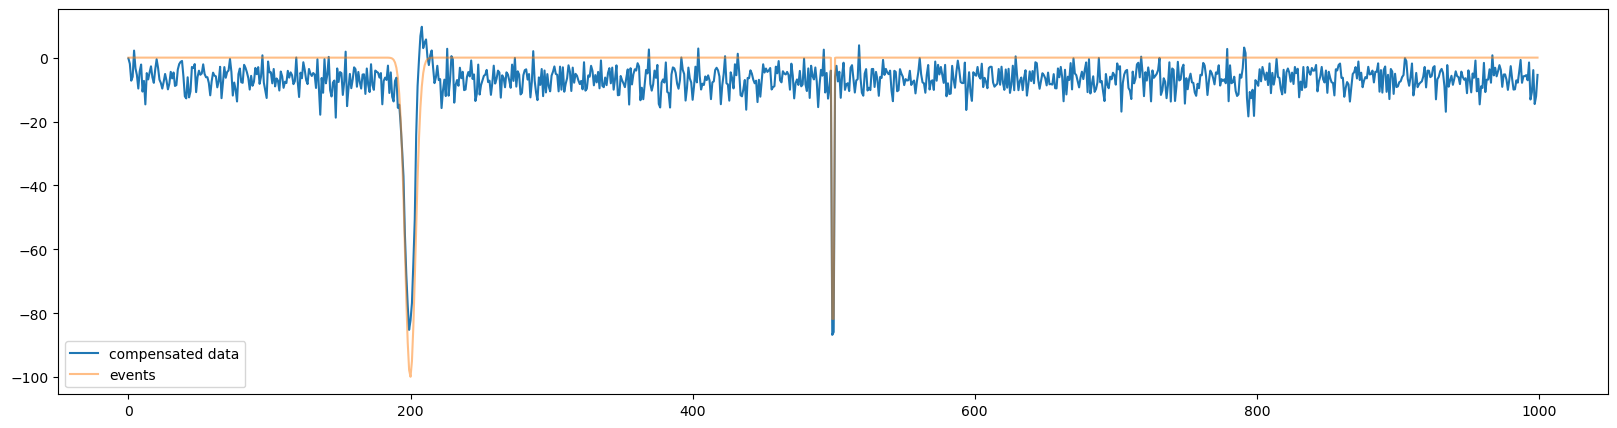

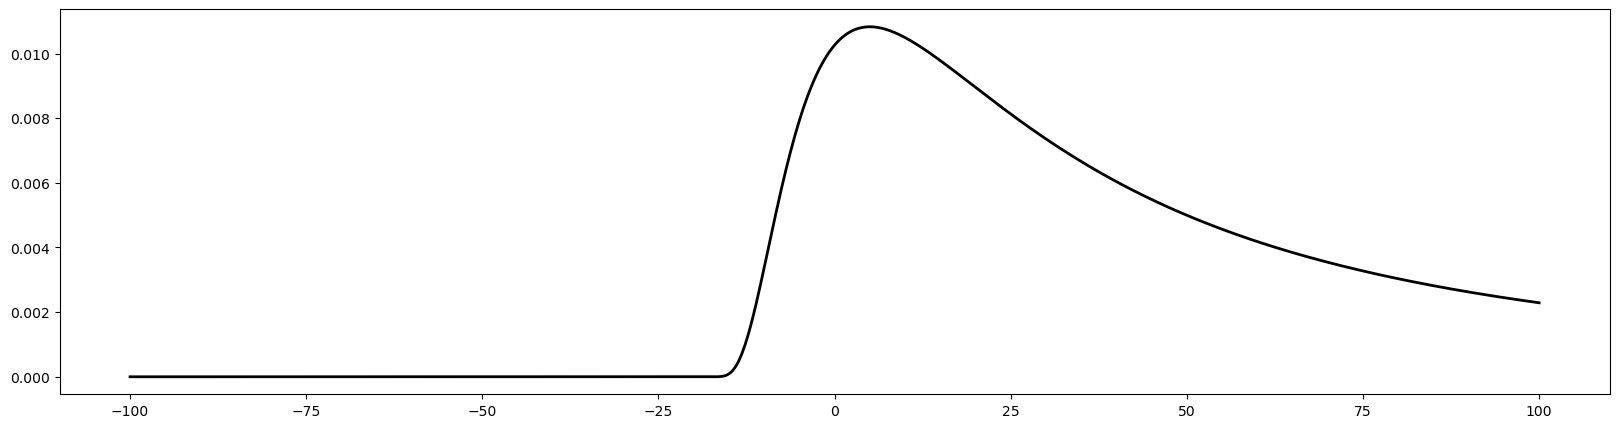

In [54]:
measurements = y_lf*2 + 6 + y_noise + y_hf
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])
#learn the temperature coefficient
pf_alpha = learn_alpha(input[0].reshape(-1, 1),measurements)

num_particles=1000
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([2, 1]),
    loc=-20,
    alpha = pf_alpha)

mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
plt.figure(figsize=(20,5))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample()
    #print(self.particles, self.weights)
    prediction = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles, marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r',alpha=0.5)

plt.plot(y_lf, label='temperature_meaurement')
plt.plot(measurements, label='measurements')
plt.plot(pf.predictions, label='PF predictions')
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(measurements - pf.predictions, label='compensated data')
plt.plot(y_hf, alpha=0.5, label='events')
plt.legend()
plt.show()
# plot noise ditribution
plt.figure(figsize=(20,5))
x = np.linspace(-100, 100, 1000)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

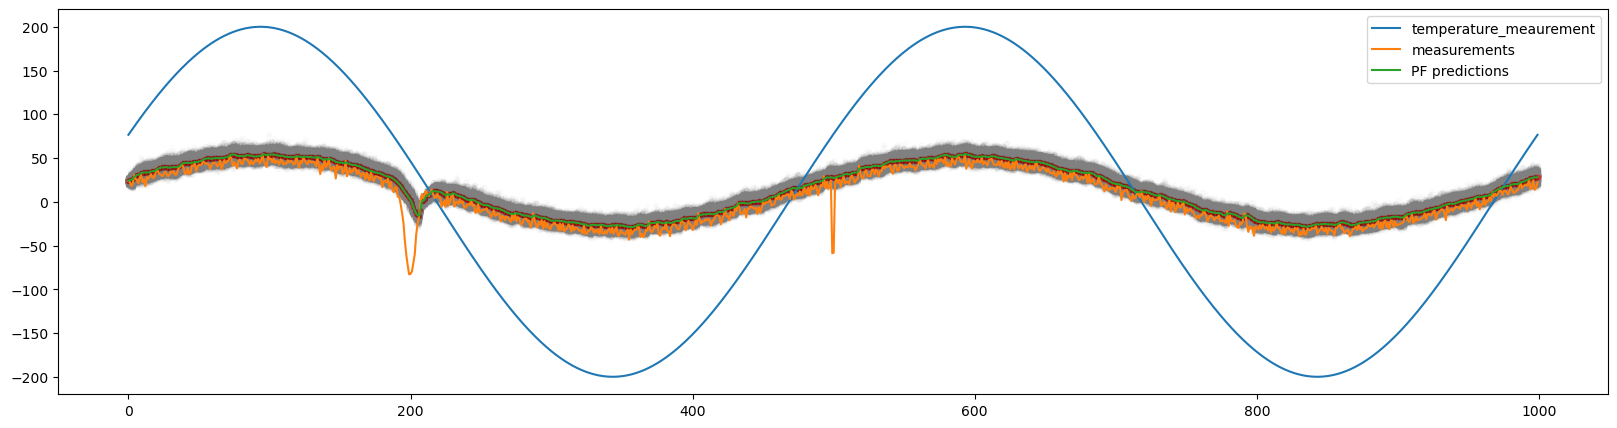

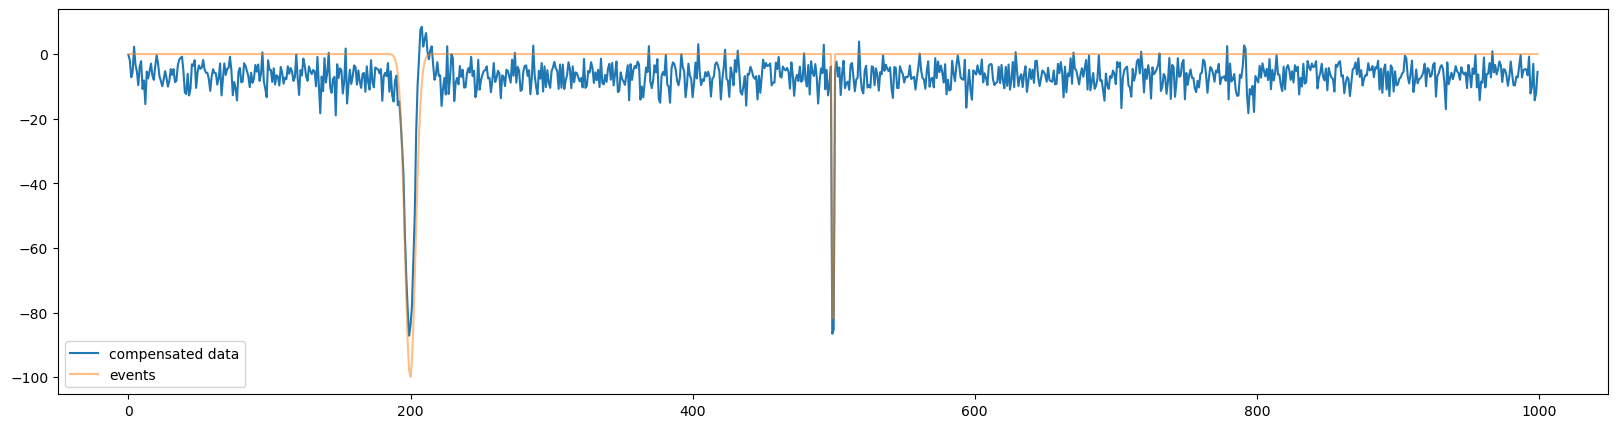

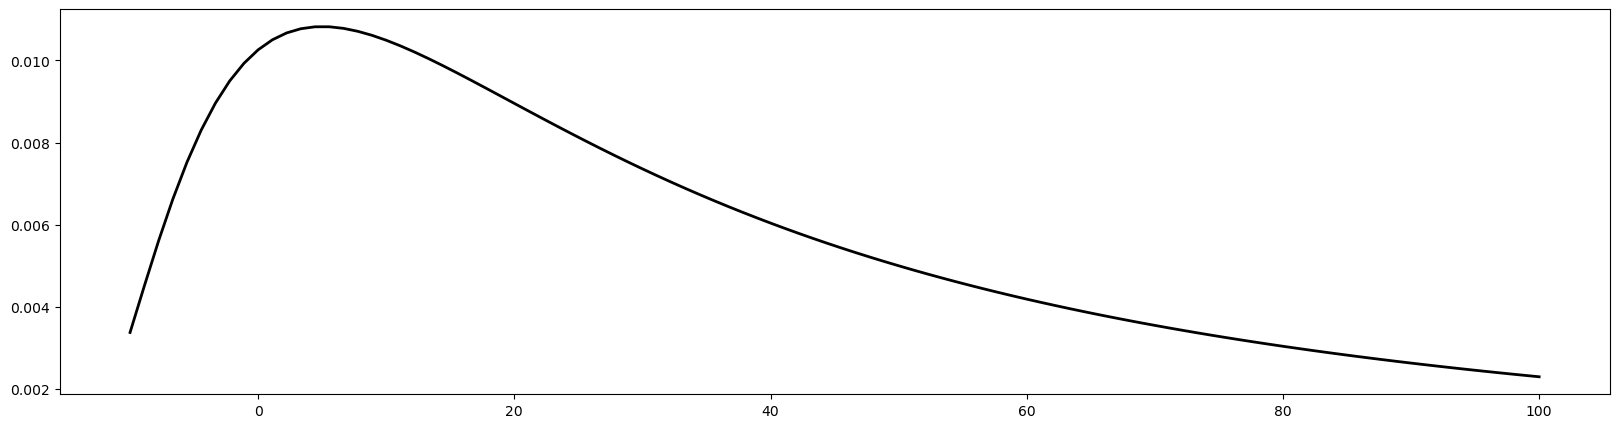

In [56]:
measurements = y_lf/5 + 6 + y_noise + y_hf
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])
#learn the temperature coefficient
pf_alpha = learn_alpha(input[0].reshape(-1, 1),measurements)

num_particles=1000
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([2, 1]),
    loc=-20,
    alpha = pf_alpha)

mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
plt.figure(figsize=(20,5))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample()
    #print(self.particles, self.weights)
    prediction = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles, marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r',alpha=0.5)

plt.plot(y_lf, label='temperature_meaurement')
plt.plot(measurements, label='measurements')
plt.plot(pf.predictions, label='PF predictions')
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(measurements - pf.predictions, label='compensated data')
plt.plot(y_hf, alpha=0.5, label='events')
plt.legend()
plt.show()
# plot noise ditribution
plt.figure(figsize=(20,5))
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

### Wrong temperature coefficient

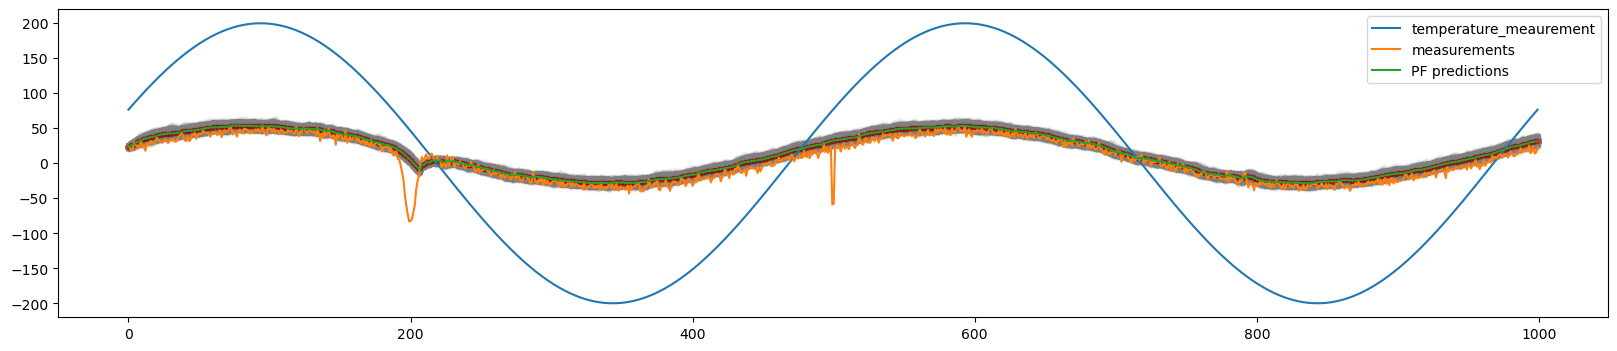

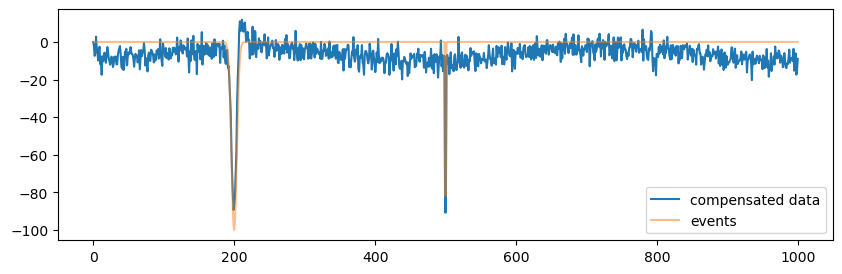

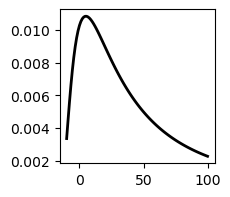

In [58]:
measurements = y_lf/5 + 6 + y_noise + y_hf
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])
#learn the temperature coefficient
pf_alpha = 2 * learn_alpha(input[0].reshape(-1, 1),measurements)

num_particles=1000
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([1, 1]),
    loc=-20,
    alpha = pf_alpha)
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
plt.figure(figsize=(20,4))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample()
    #print(self.particles, self.weights)
    prediction = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles, marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r',alpha=0.5)

plt.plot(y_lf, label='temperature_meaurement')
plt.plot(measurements, label='measurements')
plt.plot(pf.predictions, label='PF predictions')
plt.legend()
plt.show()
plt.figure(figsize=(10,3))
plt.plot(measurements - pf.predictions, label='compensated data')
plt.plot(y_hf, alpha=0.5, label='events')
plt.legend()
plt.show()
# plot noise ditribution
plt.figure(figsize=(2,2))
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

### Time delay between temperature and measurement

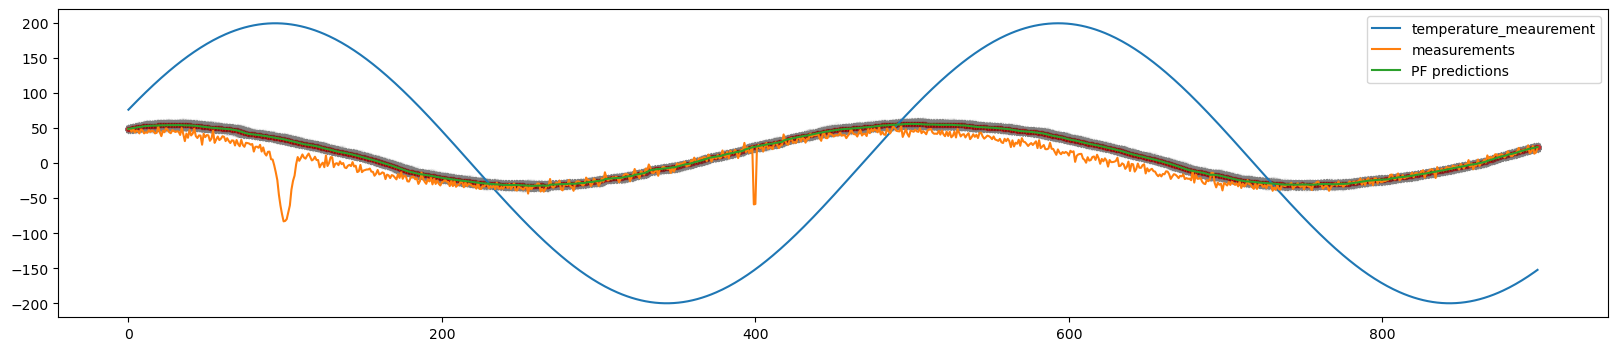

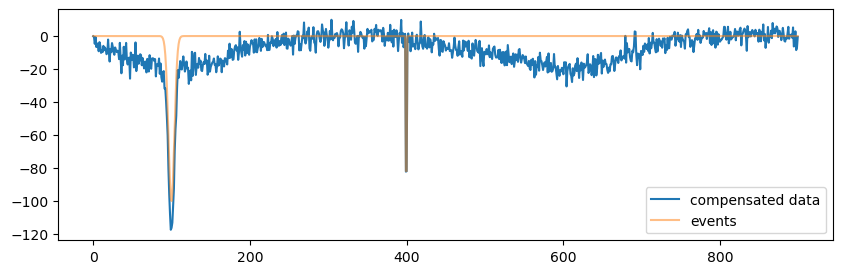

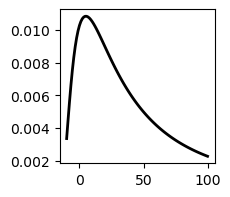

In [59]:
delay = 100
measurements = y_lf/5 + 6 + y_noise + y_hf
measurements = measurements[delay:]
input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])
input = input[:,:-delay]
#learn the temperature coefficient
pf_alpha = 2 * learn_alpha(input[0].reshape(-1, 1),measurements)

num_particles=1000
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([0.5, 1]),
    loc=-20,
    alpha = pf_alpha)

loading='compression'
mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
plt.figure(figsize=(20,4))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample()
    #print(self.particles, self.weights)
    prediction = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles, marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r',alpha=0.5)

plt.plot(input[0], label='temperature_meaurement')
plt.plot(measurements, label='measurements')
plt.plot(pf.predictions, label='PF predictions')
plt.legend()
plt.show()
plt.figure(figsize=(10,3))
plt.plot(measurements - pf.predictions, label='compensated data')
plt.plot(y_hf[delay:], alpha=0.5, label='events')
plt.legend()
plt.show()
# plot noise ditribution
plt.figure(figsize=(2,2))
x = np.linspace(-10, 100, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

##### Filter that overly follows the measurements (no detection of event)

c:\users\max\documents\owi_lab\code\packages\filter_tc\filter_tc\utils.py:134: UserWarning: No alpha and no input given, using default value of 1.0
  warnings.warn('No alpha and no input given, using default value of 1.0')


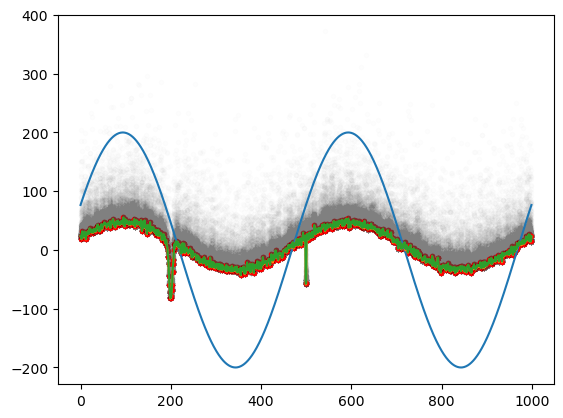

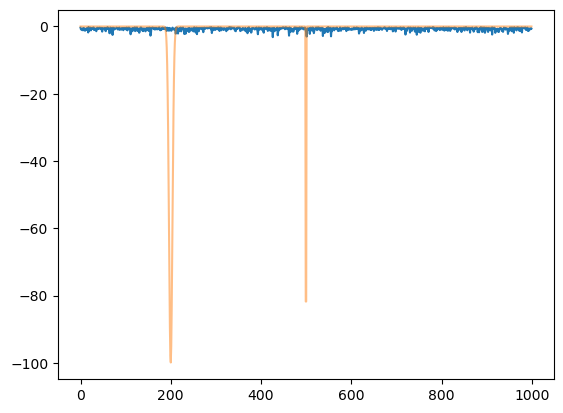

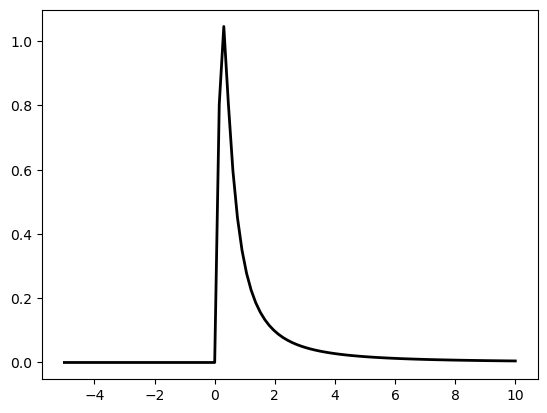

In [61]:
measurements = y_lf/5 + 6 + y_noise + y_hf


input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

num_particles=1000

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e-1,
    q_process_noise=np.array([1e2, 1e10]),
    loc = 0
)

mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample()
    #print(self.particles, self.weights)
    prediction = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles, marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r')

plt.plot(y_lf)
plt.plot(measurements)
plt.plot(pf.predictions)
plt.show()
plt.plot(measurements - pf.predictions)
plt.plot(y_hf, alpha=0.5)
plt.show()
# plot noise ditribution
x = np.linspace(-5, 10, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')

##### Filter that overly follows the inputs (no good smoothing of the actual measurements)

c:\users\max\documents\owi_lab\code\packages\filter_tc\filter_tc\utils.py:134: UserWarning: No alpha and no input given, using default value of 1.0
  warnings.warn('No alpha and no input given, using default value of 1.0')


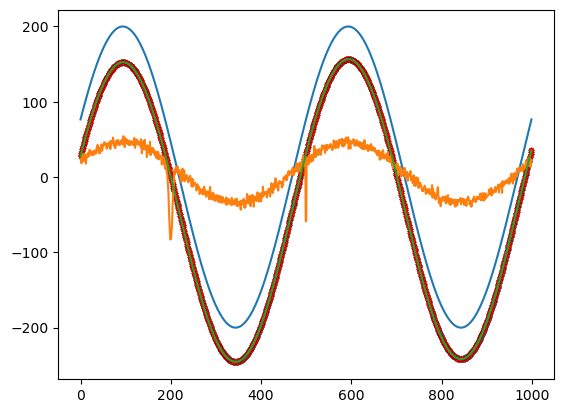

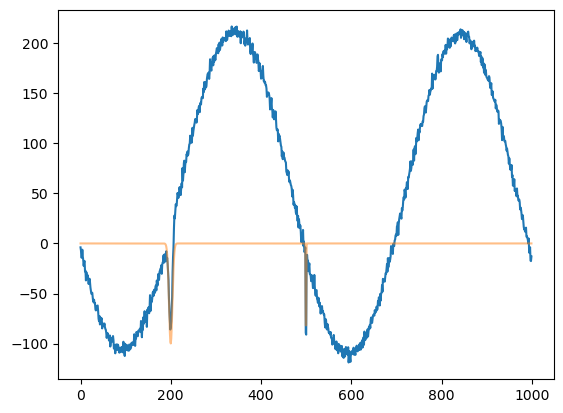

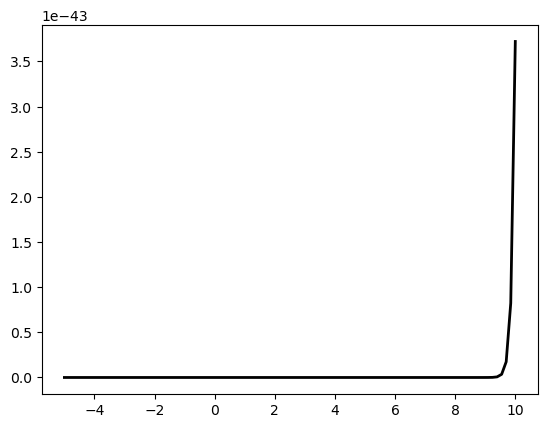

In [63]:
measurements = y_lf/5 + 6 + y_noise + y_hf

input= np.vstack([y_lf, np.insert(np.diff(y_lf),0,0)])

num_particles=1000

pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=1e3,
    q_process_noise=np.array([2e-2, 1e-1]),
    loc=0
)

mean = np.array([measurements[0], 0]) # Start with the starting variable
std = np.array([1.0, 1.0]) # TODO: @MaxWeil where does this come from, is it a setting?
# NOTE: @WoutWeijtjens this is indeed a setting to generate random particles around the mean (gaussian particles)
pf.create_gaussian_particles(mean, std)
pf.predictions = np.zeros(len(measurements))
for i, measurement in enumerate(measurements):
    pf.predict(input[:,i])
    #print(self.particles, self.weights)
    pf.update(measurement, loading=loading)
    #print(self.particles, self.weights)
    pf.simple_resample()
    #print(self.particles, self.weights)
    prediction = pf.estimate()
    #print(self.particles, self.weights)
    pf.predictions[i] = prediction

    plt.plot(np.ones(num_particles)*i,pf.particles, marker='.', color='gray', alpha=0.01, linestyle='')
    plt.plot(i, prediction, marker='.', color='r')

plt.plot(y_lf)
plt.plot(measurements)
plt.plot(pf.predictions)
plt.show()
plt.plot(measurements - pf.predictions)
plt.plot(y_hf, alpha=0.5)
plt.show()
# plot noise ditribution
x = np.linspace(-5, 10, 100)
plt.plot(x, pf.event_distribution.pdf(x), 'k-', lw=2, label='frozen pdf')
# plt.ylim([-10,10])


# ParticleFilterBank

In [64]:
from filter_tc.particle_filter import ParticleFilterBank

input = {
    'data': y_lf,
    'name': 'test_lf',
    'unit_str': '°C',
    'fs':1
}


measurements = [
    {
    'data':y_lf + y_noise + y_hf,
    'name': 'test_measurement',
    'unit_str' : 'microstrain',
    'fs':1
    },
    {
        'data': y_lf+ 100 + y_noise + y_hf,
        'name': 'test_measurement_2',
        'unit_str' : 'microstrain',
        'fs':1      
    },
    {
        'data': y_lf/5 + 50 + y_noise + y_hf,
        'name': 'test_measurement_3',
        'unit_str' : 'microstrain',
        'fs':1      
    },

]

# NOTE: Change the PF settings to fit the problem
# FIXME: Maybe think of a way to automatically find these parameters?

num_particles=1000
pf = ParticleFilter(
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([2, 1]),
    loc=-10,
    alpha = pf_alpha)

pfb = ParticleFilterBank.from_sep005(
    measurements,
    input,
    num_particles=num_particles,
    r_measurement_noise=5e1,
    q_process_noise=np.array([0.5, 1e3]),
    loc=-25)

In [66]:
for pf, m in zip(pfb, measurements):
    print(f'{pf.name}: Initial value: {np.mean(pf.particles)} vs. {m["data"][0]}')

test_measurement: Initial value: 78.89326975780317 vs. 78.88702259203558
test_measurement_2: Initial value: 178.88638298826166 vs. 178.88702259203558
test_measurement_3: Initial value: 67.65175145734916 vs. 67.65767341362121


In [67]:
filtered = pfb.filter(measurements, input)

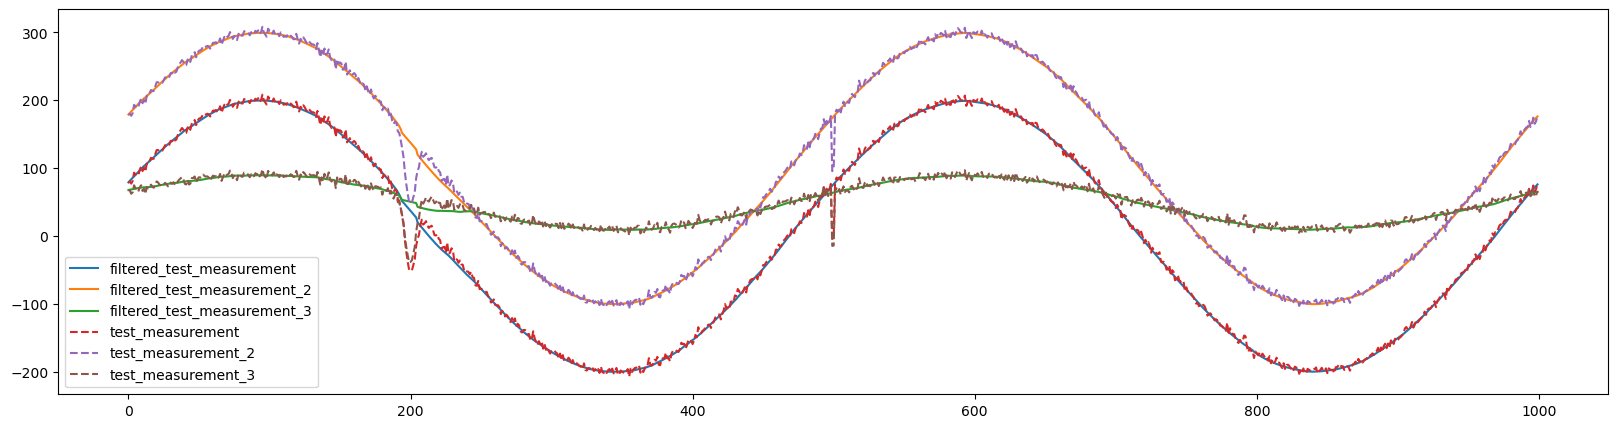

In [68]:
plt.figure(figsize=(20,5))
for fi in filtered:
    plt.plot(fi['data'], label=fi['name'])

for fi in measurements:
    plt.plot(fi['data'], label=fi['name'], linestyle='--')

#plt.plot(input['data'], label='input', linestyle='-.')
plt.legend()

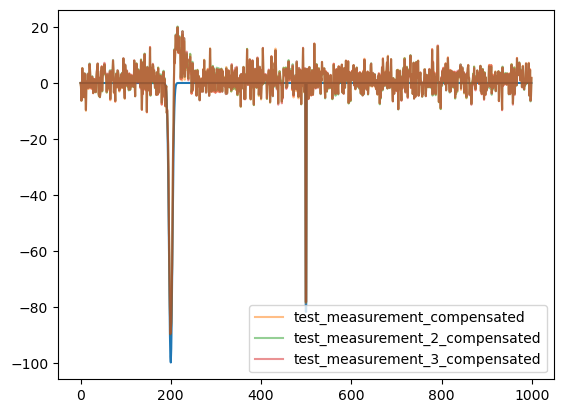

In [69]:
plt.plot(y_hf)
for i in range(len(filtered)):
    plt.plot(measurements[i]['data'] - filtered[i]['data'], label=measurements[i]['name'] + '_compensated', alpha=0.5)
plt.legend()